### Linear Kalman Filter Demo

<br>

- In this demo, I will walk through some basic problems that a linear kalman filter can solve in the following procedure
    - Parameter Setup
    - Calculations & Logic
    - Analyzing Results
<br>
<br>

- Problems to Look At
    - Weighing Gold (Static System, Time Invariant)
    - One Dimensional Constant Velocity
    - Three Dimensional Constant Acceleration

In [1]:
import os
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from trackingfilters.kalman import LinKalmanFilter as lkf

In [4]:
%load_ext autoreload
%autoreload 2

### Weighing Gold
- Although Kalman Filter is typically used in signal processing to track motion, it can also be applied on static systems

#### Problem
- Using an inaccurate weight scale (standard deviation of 5g) to weigh a gold bullion that is 1000g

#### Parameter Set up

In [70]:
measure_var = 5 ** 2
measure_noise_mat = np.array([measure_var]).reshape(-1,1) # Weight Scale Variance
init_state_vec = np.array([0]).reshape(-1,1) # Setting my initial guess of the weight to be 0
init_state_cov_mat = np.array([2500]).reshape(-1,1) # Setting my initial covariance to be high as I don't have an estimate about the true weight of the gold bullion
transition_mat = np.array([1]).reshape(-1,1) # Static System, Weight of the gold bullion does not change over time
control_mat = np.array([0]).reshape(-1,1) # No control variable
control_vec = np.array([0]).reshape(-1,1)
observation_mat = np.array([1]).reshape(-1,1) # Observe the weight
process_noise_mat = np.array([0]).reshape(-1,1) # Assume no process error

In [71]:
num_measurements = 100
true_value = 1000
measurements = measure_var * np.random.randn(num_measurements) + true_value # Assume Gaussian distribution of error

In [72]:
gold_weighter = lkf(init_state_vec=init_state_vec, 
                    init_state_cov_mat = init_state_cov_mat,
                    transition_mat=transition_mat,
                    observation_mat=observation_mat,
                    control_vec=control_vec,
                    control_mat=control_mat,
                    process_noise_mat=process_noise_mat,
                    measure_noise_mat=measure_noise_mat)

#### Updating with new measurements, Kalman Filter updates the estimate with new observations

In [73]:
cur_state_list = []
cur_cov_list = []

for measure in measurements:
    cur_state, cur_cov = gold_weighter.update(measure)
    cur_state_list.append(cur_state[0][0])
    cur_cov_list.append(cur_cov[0][0])

In [74]:
res_array = np.array([np.array(x) for x in [cur_state_list, cur_cov_list, measurements]]).transpose()
res_df = pd.DataFrame(res_array, columns=['ESTIMATE', 'COVARIANCE', 'MEASUREMENT'])
res_df['TIME'] = np.arange(0, num_measurements, 1)
res_df['ESTIMATE_ERROR'] = res_df['ESTIMATE'] - true_value
res_df['MEASUREMENT_ERROR'] = res_df['MEASUREMENT'] - true_value

#### Results
- Kalman Estimate has a smoothing effect on the estimate and converges towards the true value
- Covariance decreases over time as the filter becomes more confident about its estimate

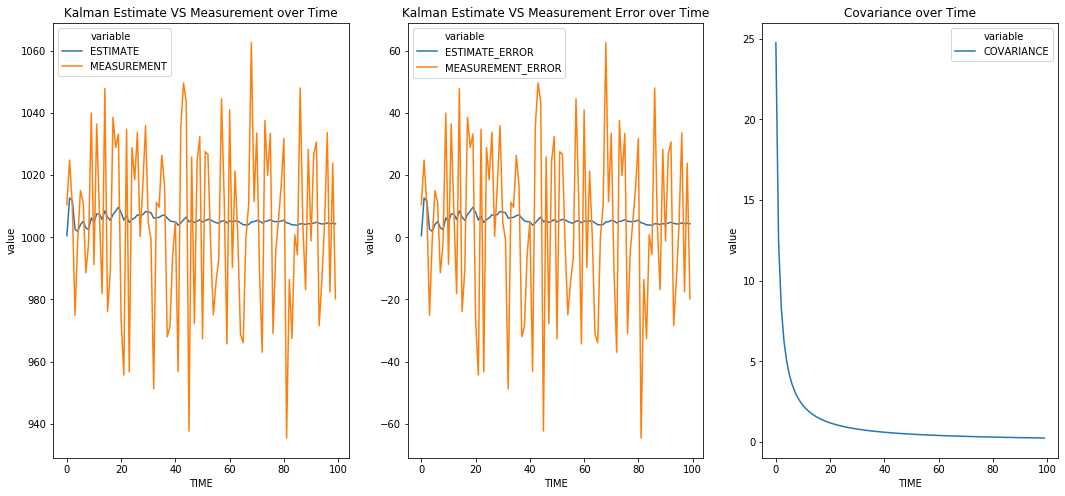

In [75]:
fig, ax= plt.subplots(1, 3, figsize=(18, 8));

fig1 = sns.lineplot(data=pd.melt(
    res_df, id_vars = ['TIME'], value_vars = ['ESTIMATE', 'MEASUREMENT']), x = 'TIME', y= 'value', hue='variable', ax=ax[0]
            );
fig1.set_title("Kalman Estimate VS Measurement over Time")

fig2 = sns.lineplot(data=pd.melt(
    res_df, id_vars = ['TIME'], value_vars = ['ESTIMATE_ERROR', 'MEASUREMENT_ERROR']), x = 'TIME', y= 'value', hue='variable', ax=ax[1]
            );
fig2.set_title("Kalman Estimate VS Measurement Error over Time");

fig3 = sns.lineplot(data=pd.melt(
    res_df, id_vars = ['TIME'], value_vars = ['COVARIANCE']), x = 'TIME', y= 'value', hue='variable', ax=ax[2]
            );
fig3.set_title("Covariance over Time");
plt.show()

### Measuring the X-position of an aircraft with constant X-velocity

- State Variable (X position)
- Control Variable (X Velocity) Assume a constant velocity of 10 

In [81]:
measure_var = 2 ** 2
measure_noise_mat = np.array([measure_var]).reshape(-1,1) # Measure Variance
init_state_vec = np.array([0]).reshape(-1,1) # Setting my initial guess of X-position to be 0
init_state_cov_mat = np.array([2500]).reshape(-1,1) # Setting my initial covariance to be high as I don't have an estimate about the true weight of the gold bullion
transition_mat = np.array([1]).reshape(-1,1) # Dynamic System, but state does not change itself
control_mat = np.array([1]).reshape(-1,1) # Control Variable is added
control_vec = np.array([10]).reshape(-1,1) # Velocity of 10
observation_mat = np.array([1]).reshape(-1,1) # Observe the position
process_noise_mat = np.array([0.1]).reshape(-1,1) # Assume minimal process error

In [82]:
num_measurements = 25
true_value = 1000
measurements = np.arange(0, num_measurements, 1) * 10 + 50 + measure_var * np.random.randn(num_measurements) ### Assume Gaussian Distribution of Error
true_value = np.arange(0, num_measurements, 1) * 10 + 50

In [83]:
position_estimator = lkf(init_state_vec=init_state_vec, 
                    init_state_cov_mat = init_state_cov_mat,
                    transition_mat=transition_mat,
                    observation_mat=observation_mat,
                    control_vec=control_vec,
                    control_mat=control_mat,
                    process_noise_mat=process_noise_mat,
                    measure_noise_mat=measure_noise_mat)

In [84]:
cur_state_list = []

for measure in measurements:
    cur_state, cur_cov = position_estimator.update(measure)
    cur_state_list.append(cur_state[0][0])
    
res_array = np.array([np.array(x) for x in [cur_state_list, true_value, measurements]]).transpose()
res_df = pd.DataFrame(res_array, columns=['ESTIMATE', 'TRUE_VALUE', 'MEASUREMENT'])
res_df['TIME'] = np.arange(0, num_measurements, 1)
res_df['ESTIMATE_ERROR'] = res_df['ESTIMATE'] - res_df['TRUE_VALUE']
res_df['MEASUREMENT_ERROR'] = res_df['MEASUREMENT'] - res_df['TRUE_VALUE']

### Kalman Filter Smoothing Effect
- Although my initial guess of position = 0 is off by 50, Kalman Filter updates quickly with new measurements to understand and guess the new position more accurately

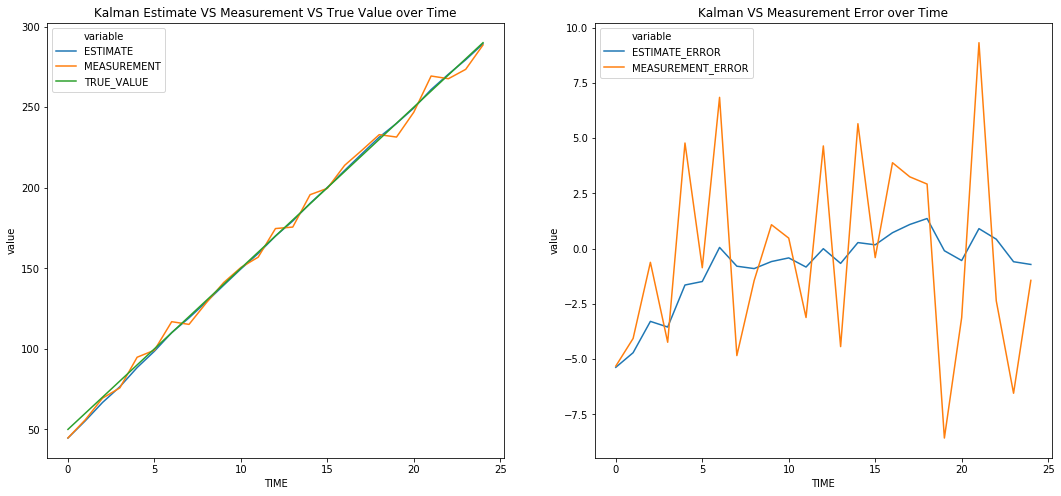

In [85]:
fig, ax= plt.subplots(1, 2, figsize=(18, 8));

fig1 = sns.lineplot(data=pd.melt(
    res_df, id_vars = ['TIME'], value_vars = ['ESTIMATE', 'MEASUREMENT', 'TRUE_VALUE']), x = 'TIME', y= 'value', hue='variable', ax=ax[0]
            );
fig1.set_title("Kalman Estimate VS Measurement VS True Value over Time")

fig2 = sns.lineplot(data=pd.melt(
    res_df, id_vars = ['TIME'], value_vars = ['ESTIMATE_ERROR', 'MEASUREMENT_ERROR']), x = 'TIME', y= 'value', hue='variable', ax=ax[1]
            );
fig2.set_title("Kalman VS Measurement Error over Time");


plt.show()

### Measuring the 3-dimensional coordinate of an aircraft with constant acceleration

- In this case, velocity and position will be considered as state variables, acceleration will be considered as control variable
- Observed variables will be position only
- Measurement time interval will be 0.25s
- I will use an auxiliary helper to calculate the transition and control matrix

#### Deriving Transition & Control Matrix & Process Noise Matrix
- We can construct a system (model) equation and an input equation and use it to derive transition and control matrix
- state_vec_derivative = sys_mat * state_vec + input_mat * control_vec 
    - (LHS is the derivative of the state_vec (x,y,z vx, vy, vz), which is (vx, vy,vz, ax,ay,az)) (v=velocity, a=acceleration)

In [368]:
delta_t = 0.25

In [369]:
sys_mat = np.zeros(shape=(6,6))
sys_mat[0][3] = 1
sys_mat[1][4] = 1
sys_mat[2][5] = 1

input_mat = np.zeros((6,3))
input_mat[3][0] = 1
input_mat[4][1] = 1
input_mat[5][2] = 1

In [370]:
print('sys mat \n', sys_mat)
print('input mat \n', input_mat)

sys mat 
 [[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
input mat 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [371]:
transition_mat, control_mat = lkf.gen_transition_control_mat(sys_mat, input_mat, delta_t
)

In [372]:
print('transition mat \n', transition_mat)
print('control mat \n', control_mat)

transition mat 
 [[1.   0.   0.   0.25 0.   0.  ]
 [0.   1.   0.   0.   0.25 0.  ]
 [0.   0.   1.   0.   0.   0.25]
 [0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   1.  ]]
control mat 
 [[0.03125 0.      0.     ]
 [0.      0.03125 0.     ]
 [0.      0.      0.03125]
 [0.25    0.      0.     ]
 [0.      0.25    0.     ]
 [0.      0.      0.25   ]]


In [373]:
### For Process Noise Matrix, it can either be time-dependent or time-independent. For time-dependent one, we can also have continous or discrete

In [374]:
process_noise_vec = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [375]:
### Time Independent
lkf.calc_process_noise_mat(process_noise_vec=process_noise_vec,
                          control_mat=control_mat,
                          time_dependence=False)

array([[0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01]])

In [376]:
### Time-Dependent Discrete
lkf.calc_process_noise_mat(process_noise_vec=process_noise_vec, 
                           control_mat=control_mat,
                           time_dependence=True,
                           delta_t=delta_t,
                           continuous=False
)

array([[9.765625e-06, 0.000000e+00, 0.000000e+00, 7.812500e-05,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 9.765625e-06, 0.000000e+00, 0.000000e+00,
        7.812500e-05, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 9.765625e-06, 0.000000e+00,
        0.000000e+00, 7.812500e-05],
       [7.812500e-05, 0.000000e+00, 0.000000e+00, 6.250000e-04,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 7.812500e-05, 0.000000e+00, 0.000000e+00,
        6.250000e-04, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 7.812500e-05, 0.000000e+00,
        0.000000e+00, 6.250000e-04]])

In [377]:
### Time-Dependent Continuous
# We need to construct a control matrix function with respect to t to use this function
# To solve this problem, we will use the time-dependent continuous process noise matrix
def control_mat_func(t):
    return np.array([
        [t**2/2, 0, 0],
        [0, t**2/2, 0],
        [0, 0, t**2/2],
        [t, 0, 0],
        [0, t, 0],
        [0, 0, t]])

process_noise_mat = lkf.calc_process_noise_mat(process_noise_vec=process_noise_vec, 
                           control_mat=control_mat,
                           time_dependence=True,
                           delta_t=delta_t,
                           continuous=True,
                           control_mat_func=control_mat_func
)
process_noise_mat

array([[4.88281250e-07, 0.00000000e+00, 0.00000000e+00, 4.88281250e-06,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.88281250e-07, 0.00000000e+00, 0.00000000e+00,
        4.88281250e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.88281250e-07, 0.00000000e+00,
        0.00000000e+00, 4.88281250e-06],
       [4.88281250e-06, 0.00000000e+00, 0.00000000e+00, 5.20833333e-05,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.88281250e-06, 0.00000000e+00, 0.00000000e+00,
        5.20833333e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.88281250e-06, 0.00000000e+00,
        0.00000000e+00, 5.20833333e-05]])

In [378]:
observation_mat = np.concatenate(
    (np.eye(3),
    np.zeros(shape=(3,3))),
    axis=1)

init_state_vec = np.array([0,0,0,1,1,1]).reshape(-1,1)
transition_mat = np.eye(6)
transition_mat[0][3] = 1
transition_mat[1][4] = 1
transition_mat[2][5] = 1

observation_mat = np.concatenate(
    (np.eye(3),
    np.zeros(shape=(3,3))),
    axis=1)

init_state_cov_mat = np.eye(6) * 50

control_vec = np.array([0,0.05, 0.15]).reshape(-1,1) # No Acceleration along X-axis

measure_var = 75 # Extremely High Measurement Error
measure_noise_mat = np.eye(3) * measure_var

In [379]:
num_measurements = 300

In [380]:
true_velocity = \
    np.transpose(
        np.arange(0, num_measurements, 1) * delta_t * control_vec + \
    np.concatenate((
        np.full(fill_value=5,shape=(1, num_measurements)),
        np.full(fill_value=5,shape=(1, num_measurements)),
        np.full(fill_value=5,shape=(1, num_measurements))
    ),axis=0)
    )

In [381]:
true_position =  np.zeros(shape=(num_measurements,3))
for i in range(1,len(true_position)):
    true_position[i] = true_position[i-1] + true_velocity[i] * delta_t + 0.5 * np.array([0,0.1,0.22]) * delta_t**2

In [382]:
measurements = true_position + measure_var * np.random.randn(num_measurements * 3).reshape(num_measurements,3)

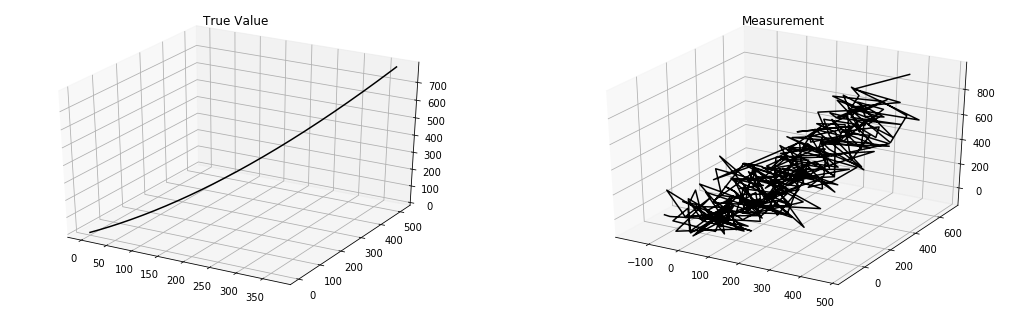

In [383]:
%matplotlib inline
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(221, projection='3d')
xline = np.take(true_position, indices=[0], axis=1).reshape(-1);
yline = np.take(true_position, indices=[1], axis=1).reshape(-1);
zline = np.take(true_position, indices=[2], axis=1).reshape(-1);
ax.plot3D(xline, yline, zline, 'black')
ax.set_title("True Value");

ax = fig.add_subplot(222, projection='3d')
xline = np.take(measurements, indices=[0], axis=1).reshape(-1);
yline = np.take(measurements, indices=[1], axis=1).reshape(-1);
zline = np.take(measurements, indices=[2], axis=1).reshape(-1);

ax.plot3D(xline, yline, zline, 'black');
ax.set_title("Measurement");


plt.show()

In [384]:
tracker = lkf(init_state_vec,
                 init_state_cov_mat,
                 transition_mat,
                 observation_mat,
                 control_vec,
                 control_mat,
                 process_noise_mat,
                 measure_noise_mat)

cur_state_x = []
cur_state_y = []
cur_state_z = []

for measure in measurements:
    measure_vec = measure.reshape(-1,1)  # Convert to Column Format
    cur_state_vec, cur_state_cov_mat = tracker.update(measure_vec)
    cur_state_x += [cur_state_vec[0][0]]
    cur_state_y += [cur_state_vec[1][0]]
    cur_state_z += [cur_state_vec[2][0]]


### Result
- In earlier stage, Kalman does not yet have enough information fed to it to make a good guess of the actual location
- However in later time, Kalman has a significant smoothing effect for prediction and much better accuracy than measurement
- We can see the measurement, if large error exists, cannot track the position of the aircraft at all

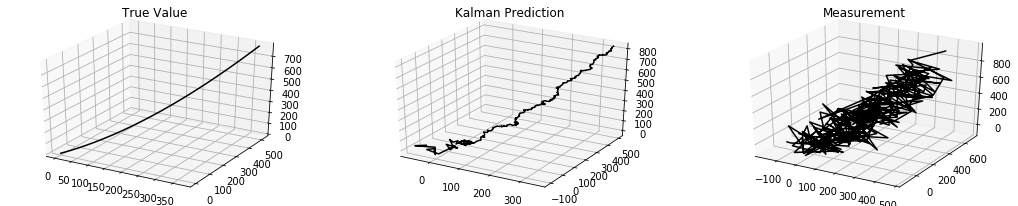

In [385]:
%matplotlib inline
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(331, projection='3d')
xline = np.take(true_position, indices=[0], axis=1).reshape(-1);
yline = np.take(true_position, indices=[1], axis=1).reshape(-1);
zline = np.take(true_position, indices=[2], axis=1).reshape(-1);
ax.plot3D(xline, yline, zline, 'black')
ax.set_title("True Value");

ax = fig.add_subplot(332, projection='3d')
xline = cur_state_x;
yline = cur_state_y;
zline = cur_state_z;

ax.plot3D(xline, yline, zline, 'black');
ax.set_title("Kalman Prediction");


ax = fig.add_subplot(333, projection='3d')
xline = np.take(measurements, indices=[0], axis=1).reshape(-1);
yline = np.take(measurements, indices=[1], axis=1).reshape(-1);
zline = np.take(measurements, indices=[2], axis=1).reshape(-1);

ax.plot3D(xline, yline, zline, 'black');
ax.set_title("Measurement");


plt.show()

In [386]:
res_array = np.array([np.array(x) for x in [
    cur_state_x,
    cur_state_y,  
    cur_state_z,
    np.take(true_position, indices=[0], axis=1).reshape(-1),
    np.take(true_position, indices=[1], axis=1).reshape(-1),
    np.take(true_position, indices=[2], axis=1).reshape(-1),
    np.take(measurements, indices=[0], axis=1).reshape(-1),
    np.take(measurements, indices=[1], axis=1).reshape(-1),
    np.take(measurements, indices=[2], axis=1).reshape(-1)]]).transpose()

In [387]:
res_df = pd.DataFrame(
    res_array, columns=['EST_X', 'EST_Y', 'EST_Z', 'TRUE_X', 'TRUE_Y', 'TRUE_Z', 'MEASURE_X', 'MEASURE_Y', 'MEASURE_Z'])

res_df['TIME'] = np.arange(0, len(res_df), 1) * delta_t

In [388]:
res_df['KALMAN_ERROR'] = np.sqrt((res_df['EST_X'] - res_df['TRUE_X'])**2 + (res_df['EST_Y'] - res_df['TRUE_Y'])**2 + (res_df['EST_Z'] - res_df['TRUE_Z'])**2)
res_df['MEASURE_ERROR'] = np.sqrt((res_df['MEASURE_X'] - res_df['TRUE_X'])**2 + (res_df['MEASURE_Y'] - res_df['TRUE_Y'])**2 + (res_df['MEASURE_Z'] - res_df['TRUE_Z'])**2)

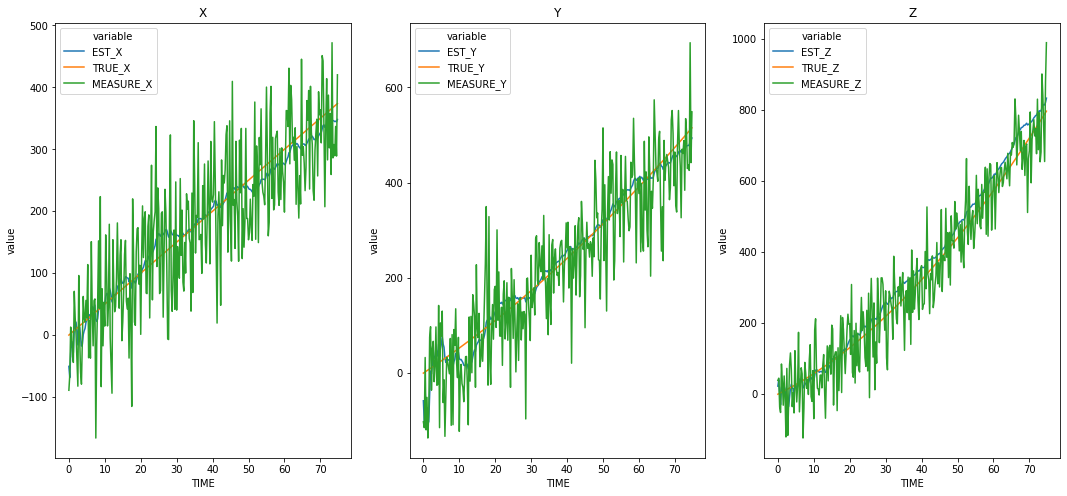

In [389]:
fig, ax= plt.subplots(1, 3, figsize=(18, 8));
for i, coordinate in enumerate(['X', 'Y', 'Z']):
    s = sns.lineplot(data=pd.melt(
        res_df, id_vars=['TIME'], value_vars=[f'EST_{coordinate}', f'TRUE_{coordinate}', f'MEASURE_{coordinate}']), x='TIME', y='value', hue='variable', ax=ax[i]);
    s.set_title(coordinate);
plt.show()


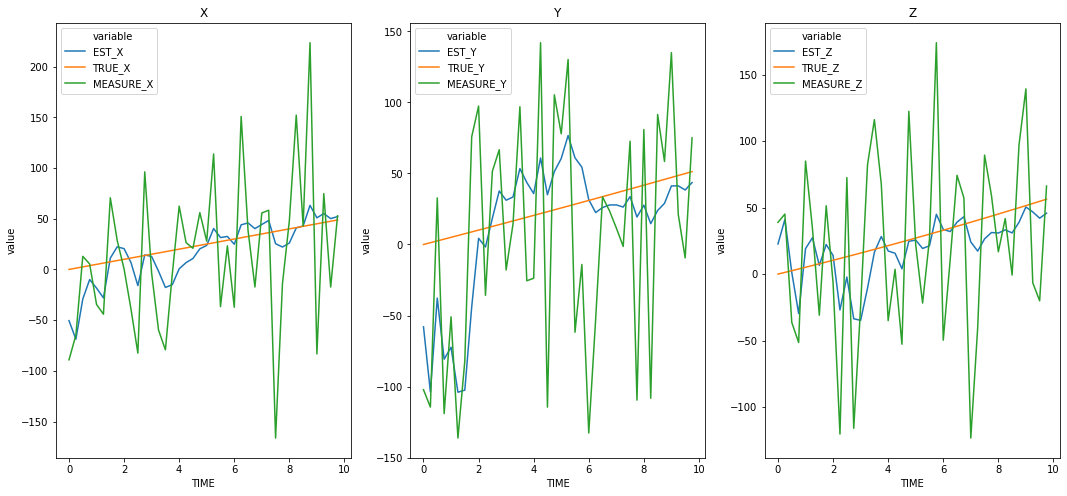

In [390]:
### The earlier results better shows the effect of Kalman Estimation
fig, ax= plt.subplots(1, 3, figsize=(18, 8));
for i, coordinate in enumerate(['X', 'Y', 'Z']):
    s = sns.lineplot(data=pd.melt(
        res_df[:40], id_vars=['TIME'], value_vars=[f'EST_{coordinate}', f'TRUE_{coordinate}', f'MEASURE_{coordinate}']), x='TIME', y='value', hue='variable', ax=ax[i]);
    s.set_title(coordinate);
plt.show()


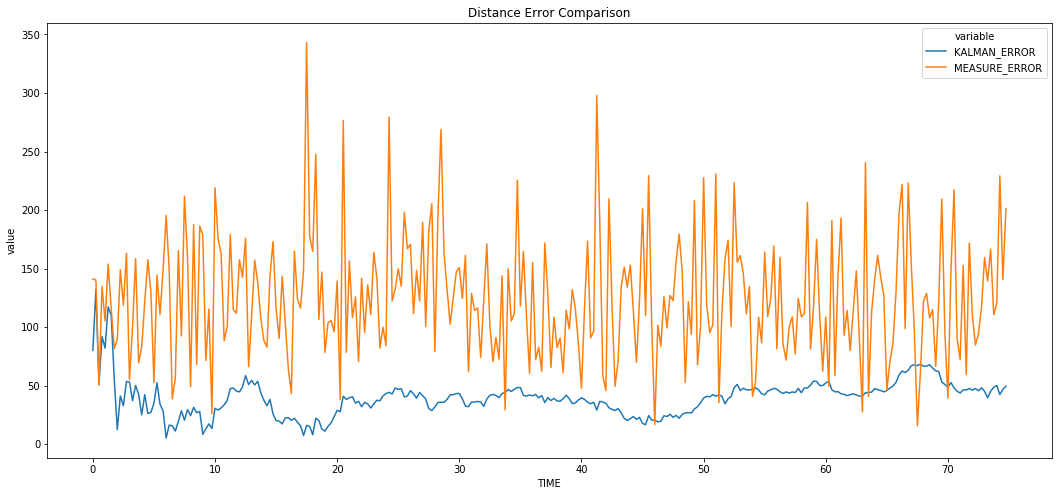

In [391]:
### Kalman prediction yields much more accurate result given high measurement error
### However given high measurement error, it is impossible for Kalman Filter to continue to improve its estimation
fig, ax= plt.subplots(figsize=(18, 8));

fig1 = sns.lineplot(
    data=pd.melt(
        res_df, id_vars=['TIME'], value_vars=['KALMAN_ERROR', 'MEASURE_ERROR']), x='TIME', y='value', hue='variable');
fig1.set_title("Distance Error Comparison");
plt.show()
